In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Loan Data

Before loading this data, you must create the "bz2" files by running the Data_cleansing notebook.

In [2]:
public_data_cat = pd.read_pickle("analysis-predictors.bz2")
public_data_y = pd.read_pickle("analysis-target.bz2")

In [3]:
public_data_y.mean()

-0.0239263066826214

## Create Design Matrix

We created two design matrices. One for training and testing on the entire testing set. Another for training and testing on a random sample so that our experiments could run faster.

#### Model Split on subset of data set

In [4]:
X_sub, y_sub = resample(public_data_cat, public_data_y, n_samples=10000)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.25, random_state=42)

#### Model Split on entire data set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    public_data_cat, public_data_y, test_size=0.25, random_state=42)

## Scaling

We experimented with the scaling method, StandardScaler.

#### StandardScaler

In [10]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X_train)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
X_train_scale = pd.DataFrame(data = scale.transform(X_train), columns = X_train.columns.tolist())
X_test_scale = pd.DataFrame(data = scale.transform(X_test), columns = X_test.columns.tolist())

In [ ]:
# create a subset of test data
X_train_sub_scale = pd.DataFrame(data = scale.transform(X_train_sub), columns = X_train.columns.tolist())
X_test_sub_scale = pd.DataFrame(data = scale.transform(X_test_sub), columns = X_test.columns.tolist())

In [ ]:
y_train.describe()

In [ ]:
X_test_scale.describe()

In [ ]:
y_test.describe()

# Exploratory Models

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train_scale, y_train)

In [ ]:
model.score(X_train_scale, y_train)

In [ ]:
model.score(X_test_scale, y_test)

model.coef_

In [ ]:
#
# Draw a bar chart showing each coefficient's magnitude and direction
#
def graph_coef(model, columns):
    cf = dict(zip(columns, model.coef_.flatten()))
    data = sorted(cf.items(),key=lambda x:abs(x[1]))
#     print(data)
    data_order, data_values = zip(*data)
    data_order = np.array(data_order)
    data_values = np.array(data_values)
    index = np.arange(len(data_order))
    
    fig,ax = plt.subplots(1,1, figsize=(10,30))

    colors = np.array([(1,0,0)]*len(data_values))
    colors[data_values >= 0] = (0,0,1)

    ax.barh(index,abs(data_values),color = colors, alpha=0.8)
    ax.set_yticklabels(data_order)
    ax.set_yticks(index)
    plt.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title("Magnitude of coefficient", fontsize=20)
    ax.set_ylabel("predictors")
    ax.set_xlabel("magnitude");

Drawing a graph of each coefficient's magnitude and direction will help us to understand what factors the model considers to be significant. Red means a negative coefficient. Blue is a positive coefficient.

In [ ]:
graph_coef(model, X_test_scale.columns)

## Lasso

In [ ]:
from sklearn.linear_model import LassoCV
LassoCVobject = LassoCV()
LassoCVobject.fit(X_train_scale, y_train)

In [ ]:
LassoCVobject.score(X_train_scale, y_train)

In [ ]:
LassoCVobject.score(X_test_scale, y_test)

In [ ]:
np.mean(LassoCVobject.predict(X_test_scale))

In [ ]:
graph_coef(LassoCVobject, X_test_scale.columns)

# Define y_train_cat for classification

For simplicity, we want to predict all the loans than satisfy a minimum return.

In [ ]:
y_train_cat = y_train > 0.10 #we can choose

In [8]:
y_test_cat = y_test > 0.10

In [9]:
X_train_scale.drop(['credit_score'],axis=1)

NameError: name 'X_train_scale' is not defined

## Logistic Regression

In [223]:
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression().fit(X_train_scale.drop(['credit_score'],axis=1), y_train_cat)

In [224]:
model_logreg.score(X_train_scale.drop(['credit_score'],axis=1), y_train_cat)

0.7245005613190321

In [225]:
model_logreg.score(X_test_scale.drop(['credit_score'],axis=1), y_test_cat)

0.724785346772492

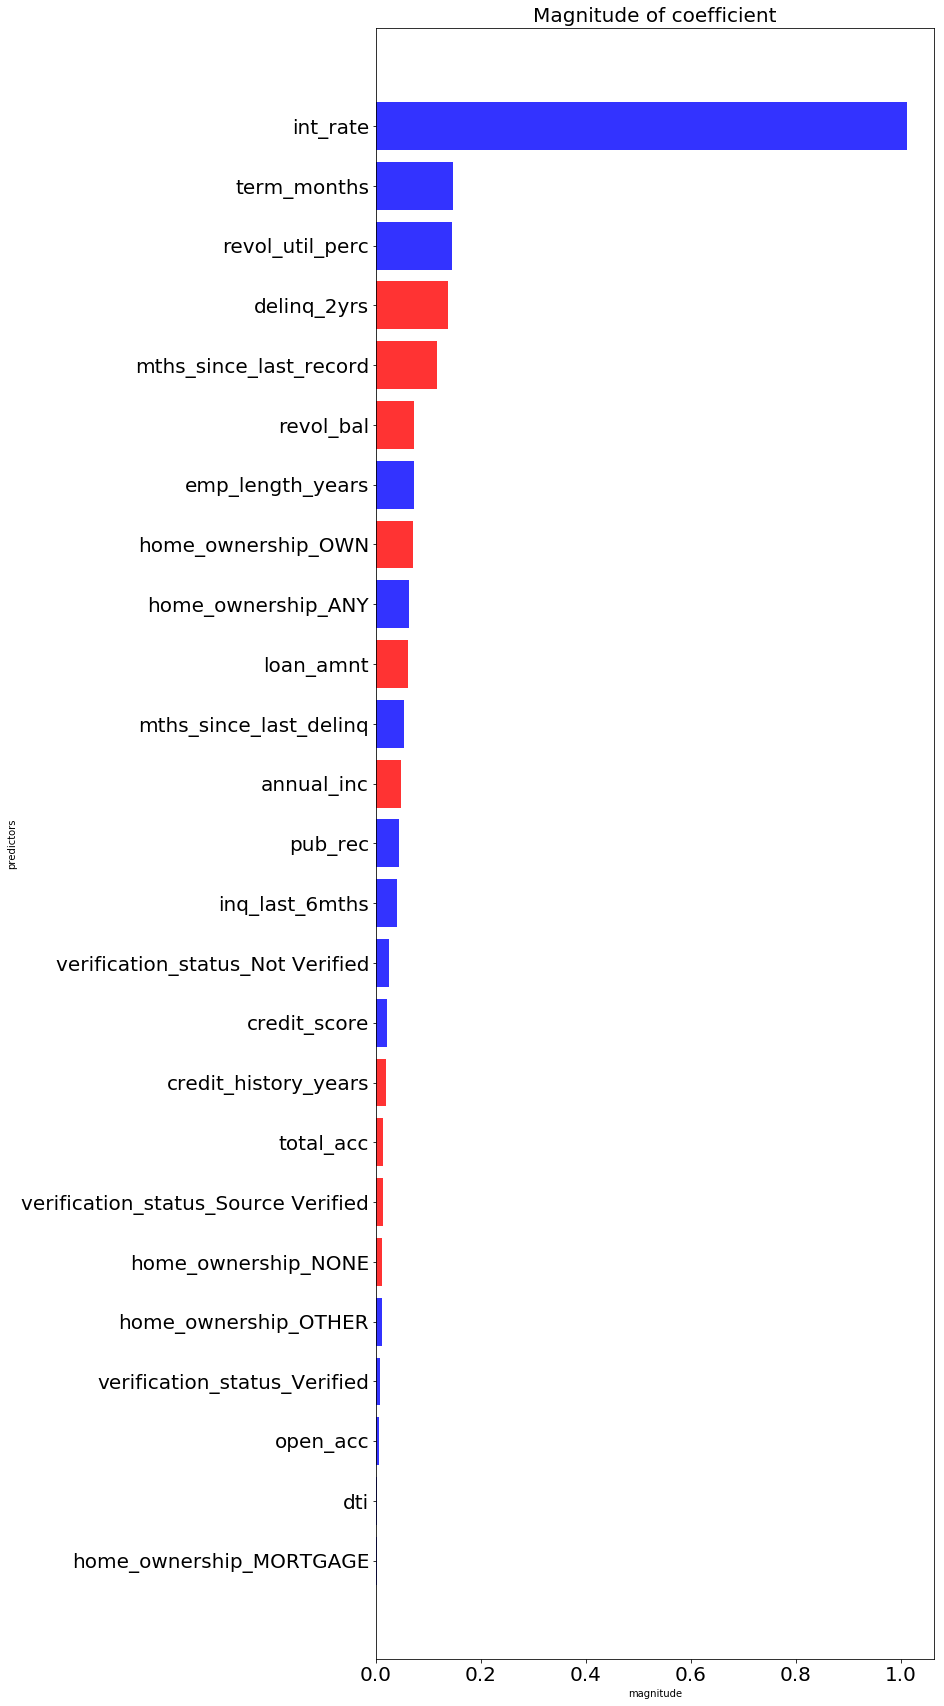

In [226]:
graph_coef(model_logreg, X_test_scale.columns)

## Strategy evaluate function for classification

The accuracy score on the model is not sufficient to determine it's quality. This is because a loan's loss can be up to 100%, whereas the gains are usually limited by the interest rate to 10-20%. Thus, a few bad loans can completely wipe out any profits from good loans. For example, if we choose 10 loans and 9 of them make 10%, but the last one is a total loss, then the overall perfomance will be negative. However, the accuracy will be 90%.

In [139]:
#
# for a model, evaluate it with the given "df" data and calculate a total profit/loss APY using
# the profit data.
#
# In the case of regression models, use "cutoff" to determine the investment criteria
#
def evaluate_strategy(model, df, profit, cutoff=None, showprint=True):
    # see where our model says to invest
    inv = model.predict(df)
    if cutoff is not None: 
        inv = inv > cutoff
        inv = inv.reshape(-1)
    # return the mean return
    if showprint:
        print("Positive result on %d out of %d (%0.2f%%)" % (inv.sum(), inv.shape[0], inv.sum() / inv.shape[0] * 100.0))
        print("Mean return of strategy:", profit[inv].mean())
        print("Overall return:", profit.mean())
    return profit[inv].mean(), profit.mean()

In [140]:
#
# for a model, evaluate it with the given "df" data and calculate a total profit/loss APY using
# the profit data.
#
# In the case of regression models, use "cutoff" to determine the investment criteria
#
def evaluate_strategy(model, df, profit, cutoff=None, showprint=True):
    # see where our model says to invest
    inv = model.predict(df)
    if cutoff is not None: 
        inv = inv > cutoff
        inv = inv.reshape(-1)
    # return the mean return
    if showprint:
        print("Positive result on %d out of %d (%0.2f%%)" % (inv.sum(), inv.shape[0], inv.sum() / inv.shape[0] * 100.0))
        print("Mean return of strategy:", profit[inv].mean())
        print("Overall return:", profit.mean())
        print("remaining", profit[~inv].mean())
    return profit[inv].mean(), profit.mean()

In [141]:
def evaluate_score(estimator, X, y):
    positive = model.predict_proba(df)[:,1] >= 0.9
    return profit[positive].mean()

In [142]:
#
# evaluate the strategy based on the probability estimates rather than the classification
# results
#
def evaluate_proba(model, df, profit, cutoff):
    positive = model.predict_proba(df)[:,1] >= cutoff
#     print(positive.shape)
    print("Percent positive investments %0.1f%%" % ((positive.sum() / profit.count()) * 100))
    print("Average return", profit[positive].mean())

In [228]:
evaluate_strategy(model_logreg, X_test_scale.drop(['credit_score'],axis=1), y_test)

Positive result on 41883 out of 246444 (16.99%)
Mean return of strategy: -0.08883488831221235
Overall return: -0.023949942502153383
remaining -0.010665024138621047


(-0.08883488831221235, -0.023949942502153383)

In [232]:
x= model_logreg.predict(X_test_scale.drop(['credit_score'],axis=1))

a =y_test>0
evaluate_strategy(model_logreg,X_test_scale.drop(['credit_score'],axis=1),y_test)

y_test[x]

ss = pd.DataFrame(data=x)
ss['e'] = y_test.values

ss.columns = ['a', 'b']

ss[ss['a']==True].b.mean()

ss

newy = y_train_cat[:1000]
newy1 = y_train[:1000]

ma = LogisticRegression().fit(X_train[:1000].drop(['credit_score'],axis=1),newy)
newy1[ma.predict(X_train[:1000].drop(['credit_score'],axis=1))]
np.random.choice(y_test[~x],100).mean()

from sklearn.metrics import accuracy_score

accuracy_score(y_train_cat,model_logreg.predict(X_train_scale.drop(['credit_score'],axis=1)))
y_train_cat.where(model_logreg.predict(X_train_scale.drop(['credit_score'],axis=1)))
index = np.where(model_logreg.predict(X_train_scale.drop(['credit_score'],axis=1))==True)[0]
# model_logreg.predict(X_train_scale).sum()

y_train.iloc[index].mean()

Positive result on 41883 out of 246444 (16.99%)
Mean return of strategy: -0.08883488831221235
Overall return: -0.023949942502153383
remaining -0.010665024138621047


-0.08838819914049031

We will use this evaluate_strategy() function to determine if how well the strategy works. In the above example, the strategy returned -0.09 or about 9% loss, so it was not good. The overall return is the return from all the other loans and represents the "random" strategy. It returned -0.02, or a 2% loss, which is better than the model, but still not good.

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\genie\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [36]:
model_rf = RandomForestClassifier(max_depth=10, max_leaf_nodes=10)

In [37]:
model_rf.fit(X_train_scale, y_train>0.01)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
model_rf.score(X_train_scale, y_train>0.01)

0.8019815238121002

In [39]:
model_rf.score(X_test_scale, y_test_cat)

0.3027624937105387

In [40]:
evaluate_strategy(model_rf, X_test_scale, y_test)

Positive result on 246444 out of 246444 (100.00%)
Mean return of strategy: -0.023949942502153383
Overall return: -0.023949942502153383


(-0.023949942502153383, -0.023949942502153383)

In [41]:
y_test.iloc[model_rf.predict(X_test_scale)==False]
(model_rf.predict(X_test_scale)==False).sum()

0

## Random Forest using probability estimates

For this case, we evaluated the strategy using probability estimates. The code below creates a Random Forest and then chooses loans where the confidence in the prediction is very high. This results in a positive return over the test data set. This is a promising result.

In [42]:
model_rf_p = RandomForestClassifier(max_depth=10, max_leaf_nodes=10)
model_rf_p.fit(X_train_scale, y_train > 0.0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
evaluate_proba(model_rf_p, X_test_scale, y_test, 0.9)

Percent positive investments 3.8%
Average return 0.026211308370964928


## Various Classifiers, loop through different target returns

One thing to consider is how the choice of our "target" return affects the model's accuracy. In other words, is the model better at predicting higher quality loans? The results below show that this is generally not the case. The graphs show that the best area of prediction is around a "target" return greater than 0. AdaBoost shows a peak at the end, so that requires more investigation, but it is probably spurious. Other than that, the models are unable to predict which loans will yield the highest returns. However, that's the very question we want to answer.

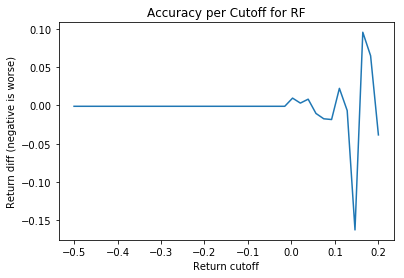

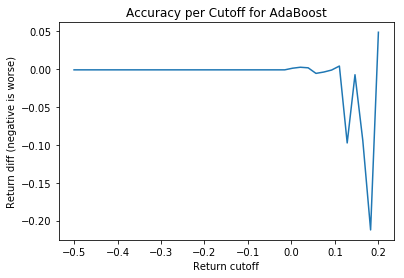

C:\Users\genie\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


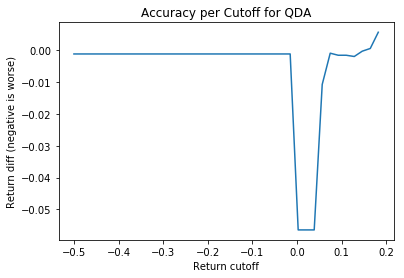

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

x = np.linspace(-0.50, 0.20, 40)

modelnames = ["RF", "AdaBoost", "QDA"]
models = [RandomForestClassifier(), AdaBoostClassifier(), QuadraticDiscriminantAnalysis()]

for name, model in zip(modelnames, models):
    y = []
    s = []
    for cutoff in x:
        positive = y_train_sub > cutoff
        model.fit(X_train_sub_scale, positive)
        score = accuracy_score(positive, model.predict(X_train_sub_scale))
        s.append(score)
        apy, mapy = evaluate_strategy(model, X_test_sub_scale, y_test_sub, cutoff, showprint=False)
        y.append(apy)
    plt.plot(x, y)
#     plt.plot(x, s)
    plt.xlabel("Return cutoff")
    plt.ylabel("Return diff (negative is worse)")
    plt.title("Accuracy per Cutoff for %s" % name)
    plt.show();

# Regression Models

Another area to consider is regression models for predicting the actual return. So far, we've worked with classification models to distinguish good loans from bad loans.
We will use sub sample of data.

## Random Forest Regeression

In [45]:
from sklearn.ensemble import RandomForestRegressor
model_rf_reg = RandomForestRegressor()
model_rf_reg.fit(X_train_sub_scale, y_train_sub)
evaluate_strategy(model_rf_reg, X_test_scale, y_test, 0.01)

Positive result on 104593 out of 246444 (42.44%)
Mean return of strategy: 0.006948964453479943
Overall return: -0.023949942502153383


(0.006948964453479943, -0.023949942502153383)

In [46]:
evaluate_strategy(model_rf_reg, X_test_scale, y_test, 0.10)

Positive result on 9529 out of 246444 (3.87%)
Mean return of strategy: 0.0009517812606956498
Overall return: -0.023949942502153383


(0.0009517812606956498, -0.023949942502153383)

In [47]:
evaluate_strategy(model_rf_reg, X_test_scale, y_test, 0.20)

Positive result on 65 out of 246444 (0.03%)
Mean return of strategy: -0.12398383072233908
Overall return: -0.023949942502153383


(-0.12398383072233908, -0.023949942502153383)

## Ada Boost Regressor

As shown below, the AdaBoost regressor is unable to make any accurate predictions.

In [86]:
from sklearn.ensemble import AdaBoostRegressor
model_adaboost = AdaBoostRegressor()
model_adaboost.fit(X_train_sub_scale, y_train_sub)
evaluate_strategy(model_adaboost, X_test_scale, y_test, 0.01)

Positive result on 183 out of 246444 (0.07%)
Mean return of strategy: -0.07142500553591209
Overall return: -0.023949942502153383


(-0.07142500553591209, -0.023949942502153383)

## Ada Boost Classifier for high returns

The graph above showed that AdaBoost may have had good results for high returns. However, running over the entire train/test set shows abysmal perfomance.

In [49]:
from sklearn.ensemble import AdaBoostClassifier
model_adaboost2 = AdaBoostClassifier()
model_adaboost2.fit(X_train_sub_scale, y_train_sub > 0.20)
evaluate_strategy(model_adaboost2, X_test_scale, y_test)

Positive result on 1507 out of 246444 (0.61%)
Mean return of strategy: -0.129632091236472
Overall return: -0.023949942502153383


(-0.129632091236472, -0.023949942502153383)

## Ada Boost Classifier with Random Forest base classifier

AdaBoost with Random Forest as base classifier takes a long time to run, so we try it with the small data set. The results are not promising.

In [52]:
from sklearn.ensemble import AdaBoostClassifier
model_adaboost3 = AdaBoostClassifier(
    learning_rate = 1,
    n_estimators=20,
    base_estimator=RandomForestClassifier(max_depth=15, max_leaf_nodes=15))
model_adaboost3.fit(X_train_sub_scale, y_train_sub > 0.10)
evaluate_strategy(model_adaboost3, X_test_sub_scale, y_test_sub)

Positive result on 83 out of 250 (33.20%)
Mean return of strategy: -0.004684714759651704
Overall return: -0.0011545893869870528


(-0.004684714759651704, -0.0011545893869870528)

As in the Random Forest, we will also consider predicting loan investments based on the probability. Only the highest probability results will be considered.

In [51]:
evaluate_proba(model_adaboost3, X_test_scale, y_test, 0.6)

Percent positive investments 0.1%
Average return -0.07827043350262608


# Polynomial Features with subset of columns

So far, all the models have used the scaled data. Now we consider using polynomial features. For these tests, in order to keep runtimes reasonable, we will use a subset of the most promising features.

In [53]:
small_columns = ['loan_amnt','term_months','int_rate','credit_score',
                 'emp_length_years','annual_inc','dti','revol_util_perc']
X_train_small = X_train[small_columns]
X_test_small = X_test[small_columns]

In [54]:
from sklearn.preprocessing import PolynomialFeatures

scale.fit(X_train_small)

poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(scale.transform(X_train_small))
X_test_poly = poly.fit_transform(scale.transform(X_test_small))

y_train_target = y_train > 0.05
y_test_target = y_test > 0.05

In [55]:
from sklearn.linear_model import LogisticRegression
poly_logreg = LogisticRegression().fit(X_train_poly, y_train_target)

In [56]:
poly_logreg.score(X_train_poly, y_train_target)

0.7259004774593213

In [57]:
poly_logreg.score(X_test_poly, y_test_target)

0.7258281800327864

In [58]:
evaluate_strategy(poly_logreg, X_train_poly, y_train)

Positive result on 658643 out of 739330 (89.09%)
Mean return of strategy: -0.022798281590794733
Overall return: -0.023918428054797717


(-0.022798281590794733, -0.023918428054797717)

In [59]:
evaluate_strategy(poly_logreg, X_test_poly, y_test)

Positive result on 219420 out of 246444 (89.03%)
Mean return of strategy: -0.022826015598729838
Overall return: -0.023949942502153383


(-0.022826015598729838, -0.023949942502153383)

# Single DecisionTree

In [60]:
from sklearn.tree import DecisionTreeClassifier

decisionmodel = DecisionTreeClassifier(max_depth=3).fit(X_train_scale, y_train_cat)
evaluate_strategy(decisionmodel, X_test_scale, y_test)

Positive result on 58861 out of 246444 (23.88%)
Mean return of strategy: -0.046710287219680534
Overall return: -0.023949942502153383


(-0.046710287219680534, -0.023949942502153383)

# LDA

In [61]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis().fit(X_train_scale, y_train > 0.10)
evaluate_strategy(lda_model, X_test_scale, y_test)

Positive result on 43665 out of 246444 (17.72%)
Mean return of strategy: -0.08914574747050502
Overall return: -0.023949942502153383


C:\Users\genie\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(-0.08914574747050502, -0.023949942502153383)

# QDA

In [62]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train_scale, y_train > 0.10)
evaluate_strategy(qda_model, X_test_scale, y_test)

C:\Users\genie\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Positive result on 84856 out of 246444 (34.43%)
Mean return of strategy: -0.057094422627577156
Overall return: -0.023949942502153383


(-0.057094422627577156, -0.023949942502153383)

In [63]:
evaluate_proba(qda_model, X_test_scale, y_test, 0.9)

Percent positive investments 10.8%
Average return -0.07048233664111787


## Neural Network

The Neural Network takes a long time to train, so we created a simple model to see if this is worth tweaking to improve perfomance.

In [64]:
y_nn = y_train > 0.05

from keras.models import Sequential
from keras.layers import Dense

model_nn = Sequential()
model_nn.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(8, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.compile(loss='binary_crossentropy', optimizer='adam')
model_nn.summary()

C:\Users\genie\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3456      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 14,065
Trainable params: 14,065
Non-trainable params: 0
_________________________________________________________________


In [65]:
model_nn.fit(X_train_scale, y_nn, epochs=10, batch_size=128, validation_split=0.2)

Train on 591464 samples, validate on 147866 samples
Epoch 1/10
591464/591464 [==============================] - 12s 21us/step - loss: 0.5549 - val_loss: 0.5528
Epoch 2/10
591464/591464 [==============================] - 11s 19us/step - loss: 0.5485 - val_loss: 0.5495
Epoch 3/10
591464/591464 [==============================] - 11s 19us/step - loss: 0.5471 - val_loss: 0.5477
Epoch 4/10
591464/591464 [==============================] - 11s 19us/step - loss: 0.5457 - val_loss: 0.5482
Epoch 5/10
591464/591464 [==============================] - 11s 19us/step - loss: 0.5448 - val_loss: 0.5456
Epoch 6/10
591464/591464 [==============================] - 11s 19us/step - loss: 0.5439 - val_loss: 0.5462
Epoch 7/10
591464/591464 [==============================] - 12s 20us/step - loss: 0.5433 - val_loss: 0.5455
Epoch 8/10
591464/591464 [==============================] - 12s 20us/step - loss: 0.5429 - val_loss: 0.5451
Epoch 9/10
591464/591464 [==============================] - 11s 19us/step - loss: 0.

The val_loss does not seem to be moving much so the model is not working well.

In [66]:
evaluate_strategy(model_nn, X_test_scale, y_test, 0.5)

Positive result on 203173 out of 246444 (82.44%)
Mean return of strategy: -0.02148096404501575
Overall return: -0.023949942502153383


(-0.02148096404501575, -0.023949942502153383)

In [67]:
p = model_nn.predict_proba(X_test_scale)
p.min(), p.max()

(0.03491678, 0.96554524)

Even though the model does not seem to work well, if we only consider the loans where the probability score is higher than 0.9, the return is 0.05, which is much higher than most of the alternative models.

In [68]:
positive = model_nn.predict_proba(X_test_scale) >= 0.9
print("Percent positive investments %0.1f%%" % ((positive.sum() / y_test.count()) * 100))
print("Average return", y_test[positive.reshape(-1)].mean())

Percent positive investments 2.8%
Average return 0.046264139380826345


## Stacking Model

Next, we considered stacking models. First, we create a simple model with 3 base models: Logistic, Random Forest and Neural Network.

In [69]:
modellist = ['Logistic', 'RF', "NN"]
modelobj = [model_logreg, model_rf, model_nn]

# create empty results that we will fill in
z = np.zeros((X_train.shape[0], len(modellist)))
stack_train = pd.DataFrame(data=z, columns=modellist)
z = np.zeros((X_test.shape[0], len(modellist)))
stack_test = pd.DataFrame(data=z, columns=modellist)

In [70]:
#make dataset with prediction.
for name, model in zip(modellist, modelobj):
    stack_train[name] = model.predict_proba(X_train_scale)
    stack_test[name] = model.predict_proba(X_test_scale)

`stack_train` and `stack_test` have one row for each sample. The columns are the probability estimates of the models.

In [71]:
stack_train.head()

,Logistic,RF,NN
0,0.854137,0.155385,0.774785
1,0.955019,0.139475,0.053919
2,0.891396,0.122595,0.547806
3,0.866139,0.102196,0.565632
4,0.518237,0.242315,0.713102


In [72]:
stack_train.describe()

,Logistic,RF,NN
count,739330.000000,739330.000000,739330.000000
mean,0.697366,0.197811,0.673068
std,0.202299,0.077171,0.184009
min,0.000391,0.093126,0.033419
25%,0.586781,0.136289,0.573606
50%,0.753391,0.179755,0.719575
75%,0.855451,0.240044,0.812876
max,0.999153,0.402899,0.961089


In [73]:
stack_test.describe()

,Logistic,RF,NN
count,246444.000000,246444.000000,246444.000000
mean,0.696849,0.198109,0.672755
std,0.202673,0.077238,0.184261
min,0.000824,0.093126,0.034917
25%,0.585872,0.136289,0.573802
50%,0.752988,0.180356,0.718911
75%,0.855298,0.240460,0.812684
max,0.995389,0.402899,0.965545


We will aggregate these with the "min" function. Thus we are interested in the loans that all models agree are good. As shown below, that's 9% of all test loans and will yield a return of 0.02.

In [75]:
# positive = stack_test.mean(axis=1) > 0.5
# positive = (stack_test > 0.75).sum(axis=1) >= 3
positive = stack_test.min(axis=1) > 0.8
print("Percent positive investments %0.1f%%" % ((positive.sum() / y_test.count()) * 100))
print("Average return", y_test[positive.values].mean())

Percent positive investments 0.0%
Average return nan


## KNN

For the sake of completeness, we will also run a KNN classifier. But the results are not promising.

In [85]:
from sklearn.neighbors import KNeighborsClassifier

KNN =KNeighborsClassifier(n_neighbors = 2).fit(X_train_sub_scale, y_train_sub > 0.10)
evaluate_strategy(KNN, X_test_sub_scale, y_test_sub)

Positive result on 0 out of 250 (0.00%)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 246444 but corresponding boolean dimension is 250